In [1]:
import os
import sys
import urllib, io
os.getcwd()
sys.path.append("..")
proj_dir = os.path.abspath('../..')

if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))

import numpy as np
import scipy.stats as stats
import pandas as pd
from random import random

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
from matplotlib import colors

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import blockworld_helpers as utils
import drawing_utils as drawing
import importlib

In [25]:
## directory & file hierarchy
proj_dir = os.path.abspath('../..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir = os.path.abspath(os.path.join(os.getcwd(),'..'))
results_dir = os.path.join(proj_dir,'results')
stim_dir = os.path.join(proj_dir,'stimuli')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
json_dir = os.path.join(results_dir,'json')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))
jefan_dir = os.path.join(analysis_dir,'jefan')
will_dir = os.path.join(analysis_dir,'will')

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       

In [29]:
stim_dir

'/Users/will/block_construction/stimuli'

In [3]:
iteration_name = 'Exp2Pilot3'
num_trials = 24 #for sanity checks

In [4]:
# Data already compiled into dataframes in CogSci 2020 Dataframe Generator

# trial_end data
trial_path = os.path.join(csv_dir,'block_silhouette_{}_good.csv'.format(iteration_name))
df = pd.read_csv(trial_path)

# # initial_block data
initial_path = os.path.join(csv_dir,'block_silhouette_initial_{}_good.csv'.format(iteration_name))
dfi = pd.read_csv(initial_path)

# # settled_block data
settled_path = os.path.join(csv_dir,'block_silhouette_settled_{}_good.csv'.format(iteration_name))
dfs = pd.read_csv(settled_path)

# # Sanity Check- same participants in each dataset.
df_participants = df.gameID.unique()
dfs_participants = dfs.gameID.unique()
assert Counter(df_participants) == Counter(dfs_participants)

n_before_outliers = len(df_participants)
print(str(n_before_outliers) + ' participants total')

49 participants total


In [5]:
dfi.columns

Index(['Unnamed: 0', 'gameID', 'trialNum', 'phase', 'condition', 'eventType',
       'targetName', 'repetition', 'targetID', 'blockNum', 'nullScore',
       'incrementalScore', 'normedIncrementalScore', 'rawScoreDiscrete',
       'incrementalNormedScoreDiscretePrevious', 'score', 'currBonus',
       'timeAbsolute', 'timeRelative', 'timeBlockSelected', 'timeBlockPlaced',
       'relativePlacementTime', 'discreteWorld', 'vertices', 'blockKind',
       'blockColorID', 'blockColor', 'blockCenterX', 'blockCenterY', 'x_index',
       'y_index', 'x_discrete', 'y_discrete', 'width_discrete',
       'height_discrete', 'buggy'],
      dtype='object')

In [8]:
dfi[['gameID','trialNum','blockNum','x_discrete', 'y_discrete', 'width_discrete',
       'height_discrete']]                         

,gameID,trialNum,blockNum,x_discrete,y_discrete,width_discrete,height_discrete
0,0145-8cab6010-6b88-4e57-b04d-b9e9b4b7c959,0,1,6,0,2,4
1,0145-8cab6010-6b88-4e57-b04d-b9e9b4b7c959,0,2,2,0,4,2
2,0145-8cab6010-6b88-4e57-b04d-b9e9b4b7c959,0,3,0,0,2,4
3,0145-8cab6010-6b88-4e57-b04d-b9e9b4b7c959,0,4,3,2,2,4
4,0145-8cab6010-6b88-4e57-b04d-b9e9b4b7c959,0,5,2,6,4,2
...,...,...,...,...,...,...,...
10671,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,23,5,2,2,2,2
10672,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,23,6,4,4,4,2
10673,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,23,7,2,4,2,2
10674,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,23,8,2,6,4,2


## Actions

Placement of block: <w,h,x,y>

Only certain placements are possible at any one time: i.e. those just above the current tower (including in holes).

Consider set of actions as possible block placements *inside the silhouette* plus an error action- placing a block anywhere outside the silhouette.


In [13]:
blocks = np.array([[1,2],[2,1],[2,2],[2,4],[4,2]]) # block dimensions
locations = np.arange(0,8) # locations to place blocks- inside 8x8 grid only

### Enumerate actions for a given target

In [46]:
target_dir = os.path.join(stim_dir,'hand_selected_e2_subset')

## load in list of structures
file_list = os.listdir(target_dir)
file_list = [x for x in file_list if not (x.startswith('.'))]

print('Loaded {} structures.'.format(len(file_list)))

target_blocks_dict = {}

## loop through list of good sequences, and build list of versions, each containing a trial list 
Meta = [] ## initialize list of all trial lists
for i,f in enumerate(file_list):
    target = pd.read_json(os.path.join(target_dir,f)) ## stim list
    targetName = f.split('.')[0]
    targetBlocks = list(target['blocks'].values)
    target_blocks_dict[targetName] = targetBlocks

Loaded 8 structures.


In [69]:
stimWidth = 8
worldWidth = 18
worldHeight = 13

target_maps = {}

for i, (target_name, block_list) in enumerate(target_blocks_dict.items()):
    #block_list = target_blocks_dict['hand_selected_009']
    target_map = np.zeros([worldWidth,worldHeight])

    for block in block_list:
        # add block to map
        width = block['width']
        height = block['height']
        blockLeft = int((worldWidth-stimWidth)/2) + block['x']
        blockBottom = block['y']
        blockTop = blockBottom + height
        blockRight = blockLeft + width

        #console.log('width', width);
        #console.log('height', height);
        #console.log('blockLeft', blockLeft);
        #console.log('blockBottom', blockBottom);
        for y in range(blockBottom,blockTop):
            for x in range(blockLeft, blockRight):
                target_map[x][y] = 1
    
    target_maps[target_name] = target_map
    

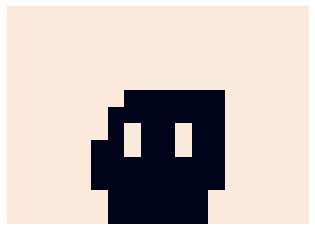

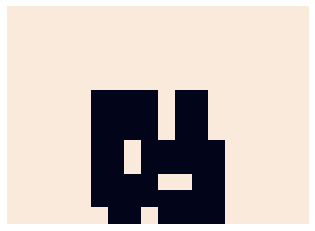

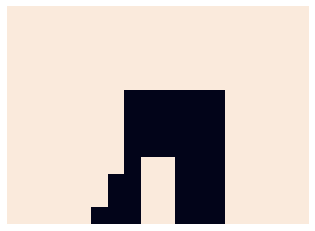

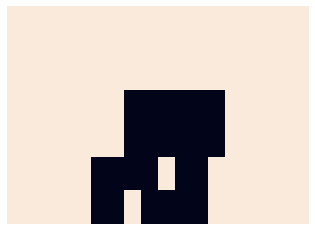

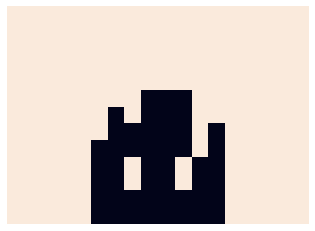

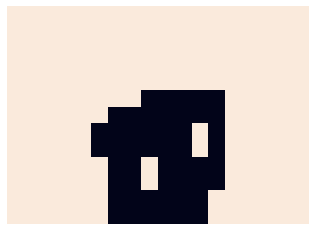

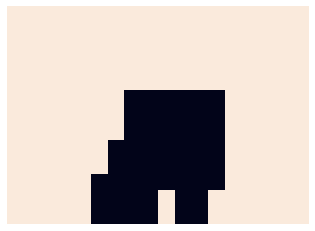

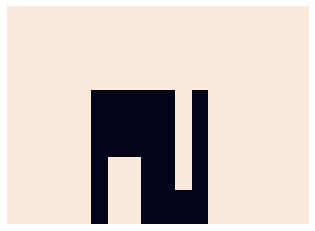

In [75]:
for i, (target_name, target_map) in enumerate(target_maps.items()):
    silhouette = 1*np.logical_not(target_map)
    silhouette = np.rot90(silhouette)
    fig, ax = plt.subplots()
    ax.axis('off')
    ax.imshow(silhouette)